In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [26]:
dir_name = "../ics_cwe/"
# models = ["pretrained_SecBert", "SecBert", "pretrained_SecureBert",  "SecureBert", "pretrained_Gpt2","Gpt2"]
#models = ["pretrained_SecBert", "SecBert", "pretrained_SecureBert",  "SecureBert", "pretrained_Gpt2"]
models = ["Gpt2_train"]
text_embeddings_train,text_embeddings_test = [],[]
our_embeddings_train, our_embeddings_test = [],[]
text_matrix = []
our_emb_matrix = []
for model in models:
    text_embeddings_train.append(np.load(dir_name+model+"/data/all_embeddings.npy"))
    text_embeddings_test.append(np.load(dir_name+model+"/data/all_embeddings_test.npy"))
    our_embeddings_train.append(np.load(dir_name+model+"/data/our_embeddings.npy"))
    our_embeddings_test.append(np.load(dir_name+model+"/data/our_embeddings_test.npy"))
    text_matrix.append(cosine_similarity(text_embeddings_test[-1], text_embeddings_train[-1]))
    our_emb_matrix.append(cosine_similarity(our_embeddings_test[-1],our_embeddings_train[-1]))


In [27]:
text_matrix[0].shape

(226, 910)

In [28]:
our_emb_matrix[0].shape

(226, 910)

In [24]:
# # Experimental
# model = "Gpt2"
# text_embeddings.append(np.load(dir_name+model+"/data/all_embeddings.npy"))
# our_embeddings.append(np.load(dir_name+model+"/data/our_embeddings_bl3.npy"))
# text_matrix.append(cosine_similarity(text_embeddings[-1]))
# our_emb_matrix.append(cosine_similarity(our_embeddings[-1]))
# models = ["pretrained_SecBert", "SecBert", "pretrained_SecureBert",  "SecureBert", "pretrained_Gpt2","Gpt2"]

In [25]:
# Graph calculation

In [29]:
weakness_hop_sim_matrix = np.load('../ics_cwe/weakness_hop_sim_matrix_test.npy')
attack_hop_sim_matrix = np.load('../ics_cwe/attack_hop_sim_matrix_test.npy')

In [30]:
from scipy.stats import spearmanr
# Flatten the matrices
def get_spearman_rank_corr_graph(matrix1,matrix2, isAttack):
    cosine_matrix1 = matrix1
    if(isAttack):
        cosine_matrix2 = matrix2[:40,:163]
    else:
        cosine_matrix2 = matrix2[40:,163:]
    # print(cosine_matrix1.shape)
    # print(cosine_matrix2.shape)
    flat_cosine_sim_matrix1 = cosine_matrix1.flatten()
    flat_cosine_sim_matrix2 = cosine_matrix2.flatten()
    
    # Compute ranks for both arrays
    ranks1 = np.argsort(np.argsort(flat_cosine_sim_matrix1))
    ranks2 = np.argsort(np.argsort(flat_cosine_sim_matrix2))
    
    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(ranks1, ranks2)
    print(f"Spearman's rank correlation: {spearman_corr}")

In [31]:
for i,model in enumerate(models):
    print("Model: ", model)
    get_spearman_rank_corr_graph(attack_hop_sim_matrix,our_emb_matrix[i], True)


Model:  Gpt2_train
Spearman's rank correlation: 0.25857428879296246


In [32]:
for i,model in enumerate(models):
    print("Model: ", model)
    get_spearman_rank_corr_graph(weakness_hop_sim_matrix,our_emb_matrix[i], False)

Model:  Gpt2_train
Spearman's rank correlation: 0.4728773208387118


In [36]:
import matplotlib.pyplot as plt

def dcg(relevance_scores):
    """ Calculate Discounted Cumulative Gain (DCG) """
    return np.sum((2 ** relevance_scores - 1) / np.log2(np.arange(1, len(relevance_scores) + 1) + 1))

def ndcg_at_k(row1, row2, k):
    """ Calculate Normalized Discounted Cumulative Gain (NDCG) at k """
    relevance_scores = row1[np.argsort(row2)[-k:]]
    ideal_relevance_scores = np.sort(row1)[-k:][::-1]
    return dcg(relevance_scores) / dcg(ideal_relevance_scores)

def NDCG_calculation_graph(matrix1,matrix2, isAttack):
    plt.figure(figsize=(5, 3))
    # Loop over all the models
    
    # models = ["PT SecBert", "FT SecBert", "PT SecureBert",  "FT SecureBert", "PT Gpt2" ,  "FT Gpt2"]
    models = ["Fine-Tuned Gpt2"]
    markers = ['o', 's', '^', 'v', '<', '>']
    for j,model in enumerate(models):
        # Define the cosine similarity matrices
        cosine_matrix1 = matrix1
        size = 1136
        if(isAttack):
            cosine_matrix2 = matrix2[j][:40,:163]
            size = 40
        else:
            cosine_matrix2 = matrix2[j][40:,163:]
            size = 186
        average_NDCG_at_k = {}
        for k in range(10, size,int(size/10)):
            # Calculate NDCG for each row
            #k = 5  # Set k to the number of elements since we want NDCG for the whole row
            ndcg_scores = []
            
            for i in range(size):
                ndcg_score = ndcg_at_k(cosine_matrix1[i], cosine_matrix2[i], k)
                ndcg_scores.append(ndcg_score)
            #print("K ", k)
            # Print NDCG scores for each row
            #print(f"NDCG scores for each row: {ndcg_scores}")
            #print(f"Average NDCG: {np.mean(ndcg_scores)}")
            # Calculate the average hit@k for the current k
            average_NDCG_at_k[k] = np.mean(ndcg_scores)
        # Plot the results
        ks = list(average_NDCG_at_k.keys())
        hits = list(average_NDCG_at_k.values())
        plt.plot(ks, hits, label=model, marker=markers[j])
        plt.xlabel('k')
        plt.ylabel('Average NDCG@k')
        plt.xticks(ks)
        plt.grid(True)
    plt.legend()
    #plt.title('Average NDCG@k for Different Values of k')
    
    if(isAttack):
        plt.savefig(dir_name+"plots/NDCG@k_with_attack.pdf", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(dir_name+"plots/NDCG@k_with_weakness.pdf", dpi=300, bbox_inches='tight')
    plt.show()

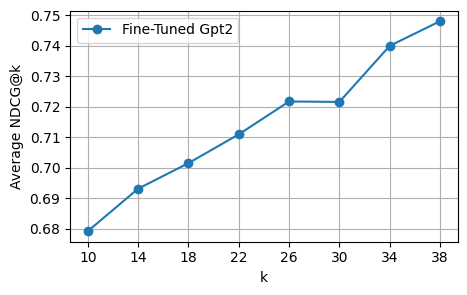

In [37]:
NDCG_calculation_graph(attack_hop_sim_matrix,our_emb_matrix, True)


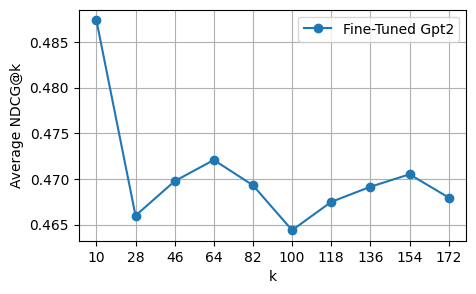

In [38]:
NDCG_calculation_graph(weakness_hop_sim_matrix,our_emb_matrix, False)

In [13]:
from scipy.stats import spearmanr
# Flatten the matrices
def get_spearman_rank_corr(matrix1,matrix2):
    flat_cosine_sim_matrix1 = matrix1.flatten()
    flat_cosine_sim_matrix2 = matrix2.flatten()
    
    # Compute ranks for both arrays
    ranks1 = np.argsort(np.argsort(flat_cosine_sim_matrix1))
    ranks2 = np.argsort(np.argsort(flat_cosine_sim_matrix2))
    
    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(ranks1, ranks2)
    print(f"Spearman's rank correlation: {spearman_corr}")

In [14]:
# models = ["pretrained_SecBert", "SecBert", "pretrained_SecureBert",  "SecureBert", "pretrained_Gpt2","Gpt2"]

for i,model in enumerate(models):
    print("Model: ", model)
    get_spearman_rank_corr(text_matrix[i],our_emb_matrix[i])

Model:  Gpt2_train
Spearman's rank correlation: 0.5866591871864141


In [ ]:
# Gpt2
# Spearman's rank correlation: 0.6097847943105891
# Pretrained Gpt2
# Spearman's rank correlation: 0.653669186712011
# # SecBert
# Spearman's rank correlation: 0.6641884030144916
# Pretrained SecBert
# Spearman's rank correlation: 0.5427275227072337
# SecureBert
# Spearman's rank correlation: 0.45052702541168266
# Pretrained secureBert
# Spearman's rank correlation: 0.4254799261180094



In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hit_k(matrix1,matrix2, title):

    # Initialize a dictionary to store average hit@k for each k
    
    plt.figure(figsize=(10, 6))
    # Loop over all the models
    # models = ["Gpt2", "pretrained_Gpt2", "SecBert", "pretrained_SecBert", "SecureBert", "pretrained_SecureBert"]
    models = ["Gpt2"]
    markers = ['o', 's', '^', 'v', '<', '>']
    for j,model in enumerate(models):
        # Define the cosine similarity matrices
        cosine_matrix1 = matrix1[j]
        cosine_matrix2 = matrix2[j]
        average_hit_at_k = {}
        # Loop over each k from 10 to 1136
        for k in range(10, 226,10):
            hit_at_k = []
        
            # Loop over each row
            for i in range(226):
                # Get the indices of the top k values in the row for both matrices
                top_k_indices_1 = np.argsort(cosine_matrix1[i])[-k:]
                top_k_indices_2 = np.argsort(cosine_matrix2[i])[-k:]
                
                # Calculate the hit@k (number of common indices in top k)
                hit_count = len(set(top_k_indices_1) & set(top_k_indices_2))
                
                # Append the result to the list
                hit_at_k.append(hit_count)
            
            # Calculate the average hit@k for the current k
            average_hit_at_k[k] = np.mean(hit_at_k)
        
        # Plot the results
        ks = list(average_hit_at_k.keys())
        hits = list(average_hit_at_k.values())
        
        
        plt.plot(ks, hits, label=model, marker=markers[j])
        plt.xlabel('k')
        plt.ylabel('Average Hit@k')
        plt.xticks(ks)
        plt.grid(True)
    plt.legend()
    plt.title('Average Hit@k for Different Values of k')
    
    plt.savefig(dir_name+"plots/hit@k_with_text.png", dpi=300, bbox_inches='tight')
    plt.show()

# # Print the results
# for k in ks:
#     print(f"Average Hit@{k}: {average_hit_at_k[k]}")

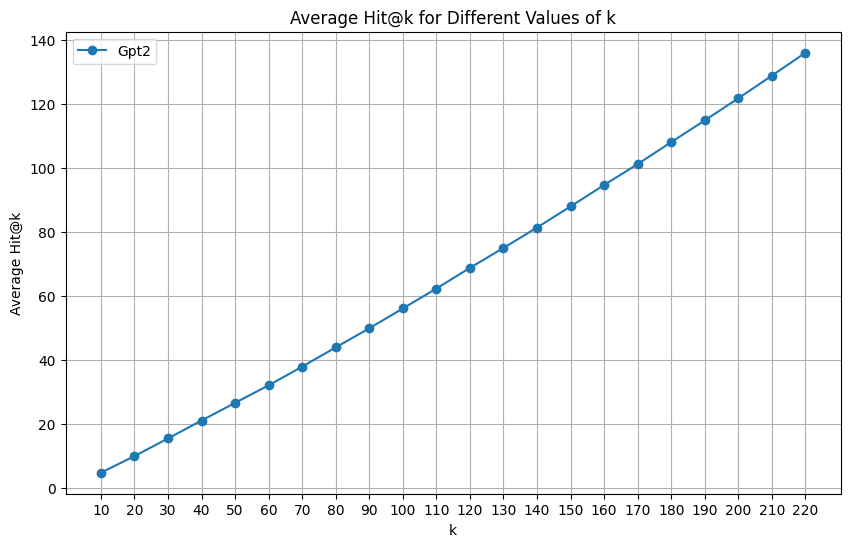

In [40]:
plot_hit_k(text_matrix,our_emb_matrix, "title")

In [41]:
def dcg(relevance_scores):
    """ Calculate Discounted Cumulative Gain (DCG) """
    return np.sum((2 ** relevance_scores - 1) / np.log2(np.arange(1, len(relevance_scores) + 1) + 1))

def ndcg_at_k(row1, row2, k):
    """ Calculate Normalized Discounted Cumulative Gain (NDCG) at k """
    relevance_scores = row1[np.argsort(row2)[-k:]]
    ideal_relevance_scores = np.sort(row1)[-k:][::-1]
    return dcg(relevance_scores) / dcg(ideal_relevance_scores)

def NDCG_calculation(matrix1,matrix2):
    plt.figure(figsize=(10, 6))
    # Loop over all the models
    # models = ["Gpt2", "pretrained_Gpt2", "SecBert", "pretrained_SecBert", "SecureBert", "pretrained_SecureBert"]
    models = ["Gpt2"]
    markers = ['o', 's', '^', 'v', '<', '>']
    for j,model in enumerate(models):
        # Define the cosine similarity matrices
        cosine_matrix1 = matrix1[j]
        cosine_matrix2 = matrix2[j]
        average_NDCG_at_k = {}
        for k in range(10, 226,10):
            # Calculate NDCG for each row
            #k = 5  # Set k to the number of elements since we want NDCG for the whole row
            ndcg_scores = []
            
            for i in range(226):
                ndcg_score = ndcg_at_k(cosine_matrix1[i], cosine_matrix2[i], k)
                ndcg_scores.append(ndcg_score)
            #print("K ", k)
            # Print NDCG scores for each row
            #print(f"NDCG scores for each row: {ndcg_scores}")
            #print(f"Average NDCG: {np.mean(ndcg_scores)}")
            # Calculate the average hit@k for the current k
            average_NDCG_at_k[k] = np.mean(ndcg_scores)
        # Plot the results
        ks = list(average_NDCG_at_k.keys())
        hits = list(average_NDCG_at_k.values())
        plt.plot(ks, hits, label=model, marker=markers[j])
        plt.xlabel('k')
        plt.ylabel('Average NDCG@k')
        plt.xticks(ks)
        plt.grid(True)
    plt.legend()
    plt.title('Average NDCG@k for Different Values of k')
    
    plt.savefig(dir_name+"plots/NDCG@k_with_text.png", dpi=300, bbox_inches='tight')
    plt.show()

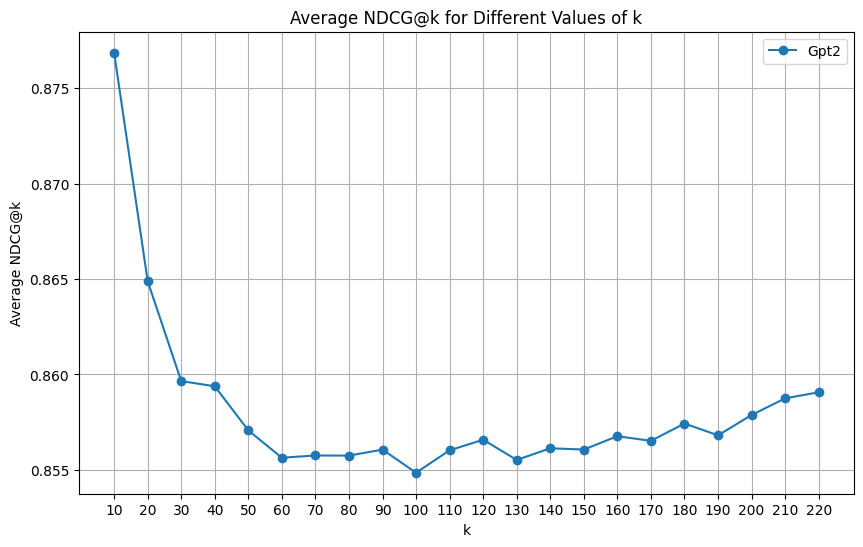

In [42]:
NDCG_calculation(text_matrix,our_emb_matrix)

In [ ]:
# Graph Calculation

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hit_k_graph(matrix1,matrix2, isAttack):
    
    # Initialize a dictionary to store average hit@k for each k
    
    plt.figure(figsize=(10, 6))
    # Loop over all the models
    #models = ["Gpt2", "pretrained_Gpt2", "SecBert", "pretrained_SecBert", "SecureBert", "pretrained_SecureBert"]
    models = ["Gpt2"]
    markers = ['o', 's', '^', 'v', '<', '>']
    if(isAttack):
        size = 40
    else:
        size = 186
    for j,model in enumerate(models):
        # Define the cosine similarity matrices
        cosine_matrix1 = matrix1
        if(isAttack):
            cosine_matrix2 = matrix2[j][:40,:163]
        else:
            cosine_matrix2 = matrix2[j][40:,163:]
        # Loop over each k from 10 to 1136
        average_hit_at_k = {}
        for k in range(10, size,int(size/20)):
            hit_at_k = []
        
            # Loop over each row
            for i in range(size):
                # Get the indices of the top k values in the row for both matrices
                top_k_indices_1 = np.argsort(cosine_matrix1[i])[-k:]
                top_k_indices_2 = np.argsort(cosine_matrix2[i])[-k:]
                
                # Calculate the hit@k (number of common indices in top k)
                hit_count = len(set(top_k_indices_1) & set(top_k_indices_2))
                # print(set(top_k_indices_1))
                # print(set(top_k_indices_2))
                
                # Append the result to the list
                hit_at_k.append(hit_count)
                # print(hit_count)
            # Calculate the average hit@k for the current k
            average_hit_at_k[k] = np.mean(hit_at_k)
        
        # Plot the results
        ks = list(average_hit_at_k.keys())
        hits = list(average_hit_at_k.values())
        
        
        plt.plot(ks, hits, label=model, marker=markers[j])
        plt.xlabel('k')
        plt.ylabel('Average Hit@k')
        plt.xticks(ks)
        plt.grid(True)
    plt.legend()
    plt.title('Average Hit@k for Different Values of k')
   
    if(isAttack):
        plt.savefig(dir_name+"plots/hit@k_with_attack_graph.png", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(dir_name+"plots/hit@k_with_weakness_graph.png", dpi=300, bbox_inches='tight')
    plt.show()
# # Print the results
# for k in ks:
#     print(f"Average Hit@{k}: {average_hit_at_k[k]}")

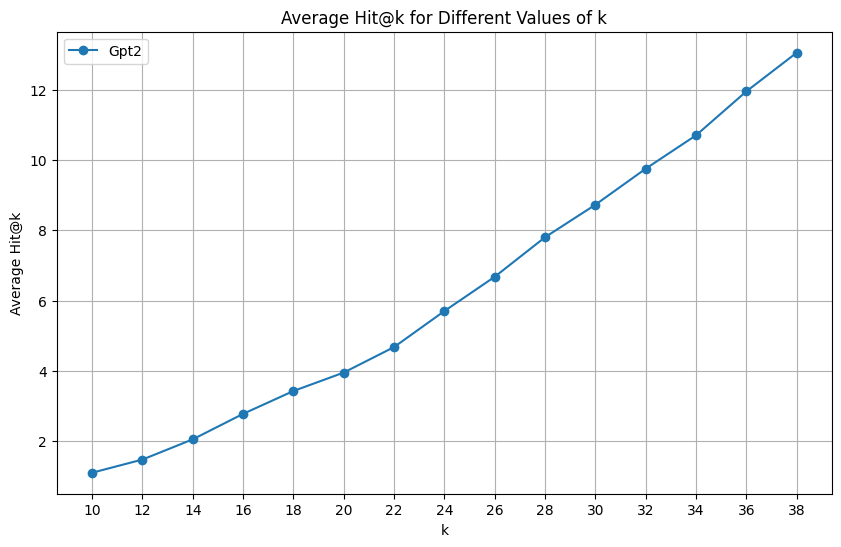

In [50]:
plot_hit_k_graph(attack_hop_sim_matrix,our_emb_matrix, True)

In [51]:
# plot_hit_k_graph(attack_hop_sim_matrix,text_matrix, True)

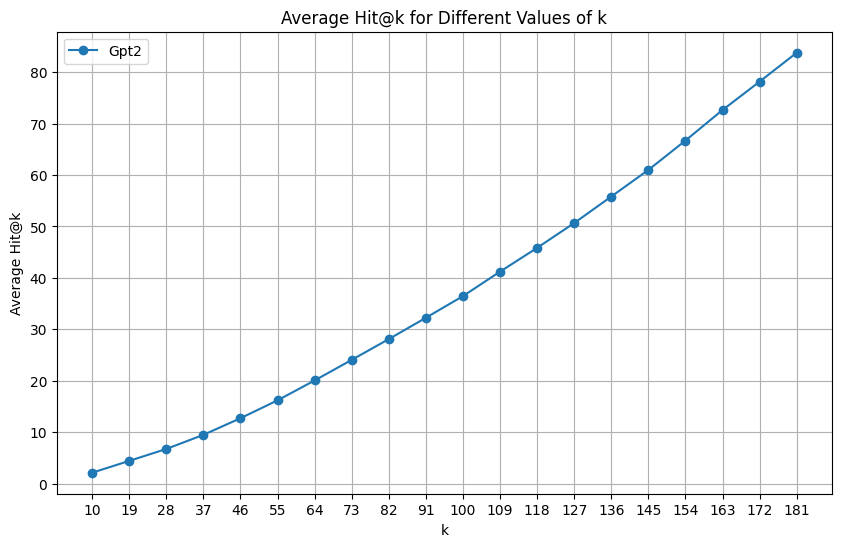

In [52]:
plot_hit_k_graph(weakness_hop_sim_matrix,our_emb_matrix, False)

In [ ]:
# plot_hit_k_graph(weakness_hop_sim_matrix,text_matrix, False)